# Visualize Galileo Magnetometer data with pyWWT

This notebook uses the PDS Search API to visualize Galileo Orbiter's magnetosphere measurement campaign with pyWWT. Thanks to PyWWT observations are displayed in their Solar System location in a 3D view.

To properly run this code, ensure that you have followed the steps outlined in the README.md file. Additionally, ensure that you have opened an "AAS Worldwide Telescope" launcher in your notebook work space. To do this simply go to File -> New Launcher and (if configured correctly) click the AAS WWT icon. See [WWTs Jupyter Application](https://pywwt.readthedocs.io/en/stable/jupyterlab.html) for troubleshooting and further setup.


## Step 0: Import Libraries and download pds4_tools

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np

import requests

import os
import io
from pathlib import Path

from datetime import datetime,timedelta

import pds4_tools
from pywwt.jupyter import WWTJupyterWidget
from pywwt.jupyter import connect_to_app
import spiceypy
from astropy.time import Time
from astropy.table import Table, hstack
from astropy import units as u

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pds.peppi as pep

## Step 1: Extract data from the PDS Search API

### Get the observational products of a Galileo Magnetometer collection

Utilize the PDS Search API to list the magnetometer observational products of a Galileo Orbiter's collection in a pandas dataframe.


First step: 
- Grab the LID and apply it to URL

In [2]:
client = pep.PDSRegistryClient()
#Low-res magnetometer data
collection_lid = "urn:nasa:pds:galileo-mag-jup-calibrated:data-magspheric-survey::1.0"
field_names = [ "lid", "vid", "pds:Time_Coordinates.pds:start_date_time",
    "pds:Time_Coordinates.pds:stop_date_time", "pds:Target_Identification.pds:name",
    "ops:Label_File_Info.ops:file_ref"]
#User specified time range
start_time = datetime.fromisoformat('1996-07-19T11:00:00+00:00')
end_time = datetime.fromisoformat('1997-08-19T15:00:00+00:00')
products = pep.Products(client).of_collection(collection_lid).fields(field_names).after(start_time).before(end_time)
products_df = products.as_dataframe()
print(products_df)

                                                    vid  \
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0   
urn:nasa:pds:galileo-mag-jup-calibrated:data-ma...  1.0 

### Utilize pds4_tools utility to load each observational product dataset.

In the collection, observational products in 2 coordinate systems are proposed (`sys3` or `irc`). We only select the observational products using the `irc` coordinate system.

In [3]:
xml_urls = [xml_url for xml_url in products_df['ops:Label_File_Info.ops:file_ref']  if 'IRC' in xml_url]

data = dict()
for ind,xml_url in enumerate(xml_urls):
    prod_struct = pds4_tools.read(xml_url, quiet = True)
    layer_name = Path(xml_url).stem
    data[layer_name] = list(prod_struct[0]['SAMPLE TIME', 'B-FIELD MAGNITUDE'])


### Plot magnetic field magnitude time series

/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **

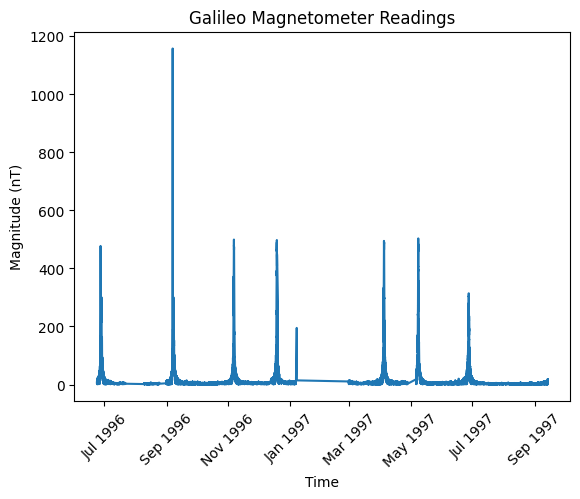

In [4]:
# reshape arrays
data_as_list = sum(data.values(), [])
mag_times, mag_measurements = zip(*data_as_list)
mag_times = [datetime.fromisoformat(d) for d in mag_times]

fig, ax = plt.subplots()
cm = ax.plot(mag_times,mag_measurements)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("Magnitude (nT)")
plt.title("Galileo Magnetometer Readings")

plt.show()

## Step 2: Obtain ephemeris for magnetometer measurements

Obtain the position at each magnetometer measurement timestamp using spiceypy.

***Note: You can change the number of data points you would like to plot by changing the sample variable. The higher it is, the fewer data points you will plot.***

### Load Spice Kernels

Spice kernels are used to compute the location of the spacecraft at given date/time.

Use spiceypy and planetarypy library.

DOES NOT WORK FOR GALILEO YET

In [5]:
#from planetarypy.spice.kernels import datasets
#from planetarypy.spice.kernels import get_metakernel_and_files
#kernel_dir = ".spice_kernels"
#get_metakernel_and_files(
#   "galileo", 
#    mag_times[0].strftime("%Y-%j"), # we need a format like "2020-001"
#    mag_times[-1].strftime("%Y-%j"), # we need a format like "2020-001"
#    kernel_dir
#)
#for file in glob.glob(kernel_dir + "/*"):
#    spiceypy.furnsh(file_path)

In [6]:
# trying to make that section oboslete with previous cell
def download_and_load_spice_kernel(p_url):
    if not os.access('.spice_kernels',os.F_OK):
        os.mkdir('.spice_kernels')

    kernel_dir = os.path.join(".spice_kernels")
    os.makedirs(kernel_dir, exist_ok=True)
    file_path = os.path.join(kernel_dir, os.path.basename(p_url))
    if not os.path.exists(file_path):
        r = requests.get(url, allow_redirects=True)
        if r.status_code == 200:
            print('Successfully loaded:',os.path.basename(p_url))

            open(file_path, "wb").write(r.content)
    else:
        print('"',os.path.basename(p_url), '" already exists. Skipping download.')
    spiceypy.furnsh(file_path)
    
KERNEL_URLS = [
    #generic LSK
    "https://naif.jpl.nasa.gov/pub/naif/pds/data/ody-m-spice-6-v1.0/odsp_1000/data/lsk/naif0008.tls",
    #Galileo SC SPK
    "https://naif.jpl.nasa.gov/pub/naif/GLL/kernels/spk/gll_951120_021126_raj2021.bsp",
    # Leap seconds kernel
    "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls",
]
for url in KERNEL_URLS:
    download_and_load_spice_kernel(url)
            

" naif0008.tls " already exists. Skipping download.
" gll_951120_021126_raj2021.bsp " already exists. Skipping download.
" naif0012.tls " already exists. Skipping download.


### Compute spacecraft position for each magnetometer measurement.

In [7]:
sample = 100

mag_ephem_data = []

mag_dict = {}
for layer, layer_data in data.items():
    t, mag = zip(*layer_data)
    et = spiceypy.str2et(t[::sample])
    states, time = spiceypy.spkezr( '5', et, 'J2000', 'LT+S', '-77')
    ephem = [coord[0:3] for coord in states]
    ephem_np = np.array(ephem)
    mag_np = [list(mag[0::sample])]
    mag_dict[layer] = hstack([Table(mag_np, names=['B-FIELD MAGNITUDE']), Table(ephem_np, names = ['X', 'Y', 'Z'])] )
    

## Step 4: display data in pyWWT Solar System 3D view

### Connect pyWWT Widget

***Before proceeding, ensure that you have another tab open in the notebook for the AAS WorldWide Telescope widget***

Instantiate the WWTJupyterWidget and await connection.

In [8]:
wwt = WWTJupyterWidget()
wwt = await connect_to_app().becomes_ready()
print('Successful Connection')
wwt.reset()

Successful Connection


### Load data into pyWWT window

Set the WWT view to the solar system and load in the magnetometer data and ephemeris data via table layers. Once complete, in the pyWWT widget the view will be centered on Jupiter. Zoom in to see the results!

In [9]:
wwt.set_current_time(Time('1995-12-07 15:21:01.776000'))
wwt.set_view("solar system")

#Visualize planetary orbit lines/paths
wwt.solar_system.orbits = True

min_mag = min(mag_measurements)
max_mag = max(mag_measurements)

for layer_name, layer_data in mag_dict.items():
    layer = wwt.layers.add_table_layer(table = layer_data, frame = 'jupiter',
                                      coord_type = 'rectangular',
                                      x_att = 'X', y_att = 'Y', z_att = 'Z', id = layer_name)
    layer.xyz_unit = 'km'
    layer.far_side_visible = True

    layer.cmap = 'plasma'
    layer.cmap_att = 'B-FIELD MAGNITUDE'
    layer.cmap.vmin = min_mag
    layer.cmap.vmax = max_mag

    layer.size_scale = 250
    layer.far_side_visible = True
    layer.marker_type = 'point'
    layer.opacity = 0.25

    # layer.name = "name"
    layer.marker_scale = 'world'

### Set view point on Jupiter

Zoom in on Jupiter to see the trajectory of Galileo with the Magnetemeter measures.


In [12]:
# need to be called twice
for _ in range(2):
    wwt.solar_system.track_object('Jupiter')


# Show the colormap

We don't know how to add it yet to pyWWT viewer

/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **

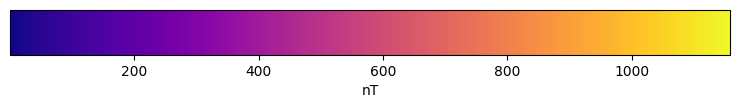

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=min_mag, vmax=max_mag)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('nT')


plt.show()

### Animation (Work In Progress)

Note the below code is still a work in progress and will not function as intended. Commenting out for the time being to avoid confusion. (and failure if you try to execute it)

In [ ]:
# start_time = ephem_tab['Time'][0]
# theta_dot = 1.76**-4 *3600 # rad/hour
# thetas = [theta_dot * (datetime.fromisoformat(start_time) - datetime.fromisoformat(curr_time)).total_seconds()/3600 for curr_time in ephem_tab['Time']]

# trans_mat = [np.array([[np.cos(theta), -np.sin(theta)] , [np.sin(theta), np.cos(theta)]]) for theta in thetas]

# trans_xy = [np.dot(trans_mat,np.array([[x] , [y]])) for x,y in zip(ephem_tab['X'],ephem_tab['Y'])]

# for i in range(len(ephem_tab)):
#     trans_mat = [np.array([np.cos(thetas[i]), -np.sin(thetas[i])] , [np.sin(thetas[i]), np.cos(thetas[i])])]
#     trans_xy[i] = [np.dot(trans_mat,np.array([x] , [y])) for x,y in zip(ephem_tab['X'][i],ephem_tab['Y'])[i]]
   

# eph.time_series = True
# eph.time_att = 'Time'
# eph.time_decay = 500 * u.hour

# layer.time_series = True
# layer.time_att = 'Time'
# layer.time_decay = 10000 * u.hour

# my_time = Time('1996-12-07 15:21:01.776000')
# wwt.set_current_time(my_time)

# wwt.play_time(rate=10000)


In [ ]:
wwt.pause_time()